# Final Project: Daniel Bishop

## Research Question 1

Given the known link between one subtropical High and a regional fall precipitation trend, can we identify a global pattern in fall precipitation and subtropical High pressure intensity?

    Hypothesis: Global precipitation patterns will exist along the western edge of subtropical Highs.

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#Read in GPCC Precipitation & NCEP-NCAR Reanalysis Sea-Level Pressure data
#1901-2017 GPCC Monthly Precipitation
ds_prec = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcc/full_v7/precip.mon.total.1x1.v7.nc')
ds_slp = xr.open_dataset('http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface/slp.mon.mean.nc')  #1948-2017 Monthly Sea-Level Pressure

import warnings
warnings.filterwarnings('ignore')  #Ignore warning from land-sea mask (indicates time is unreadable)
ds_lnd = xr.open_dataset('land.nc')  #NCEP Land-Sea Mask
warnings.filterwarnings('default')  #Turn warnings back on
lndAv = ds_lnd.land.mean(dim='time') #Pull out lat/lon land mask


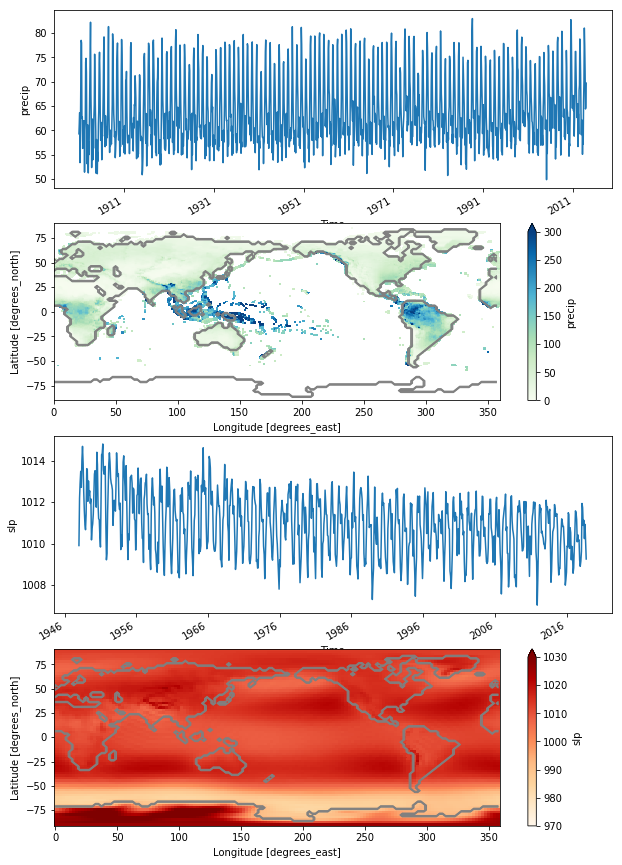

In [9]:
#Plot global and time mean of Prec and SLP data
fig = plt.figure(figsize=(10,15))  #Initialize figure size
#Initialize 3 subplots, assign to variable names ax
axes = fig.subplots(nrows=4)
ax = axes

ds_prec.precip.mean(dim=['lat','lon']).plot(ax=ax[0]);
ds_prec.precip.mean(dim='time').plot(ax=ax[1],cmap='GnBu',vmin=0,vmax=300);
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
ds_slp.slp.mean(dim=['lat','lon']).plot(ax=ax[2]);
ds_slp.slp.mean(dim='time').plot(ax=ax[3],cmap='OrRd',vmin=970,vmax=1030);
lndAv.plot.contour(ax=ax[3],colors='grey',linewidths=1);

In [10]:
#Note units of each variable
print(ds_prec.precip.attrs['long_name'])
print(ds_prec.precip.attrs['units'])

print(ds_slp.slp.attrs['long_name'])
print(ds_slp.slp.attrs['units'])

GPCC Monthly total of precipitation
mm
Sea Level Pressure
millibars


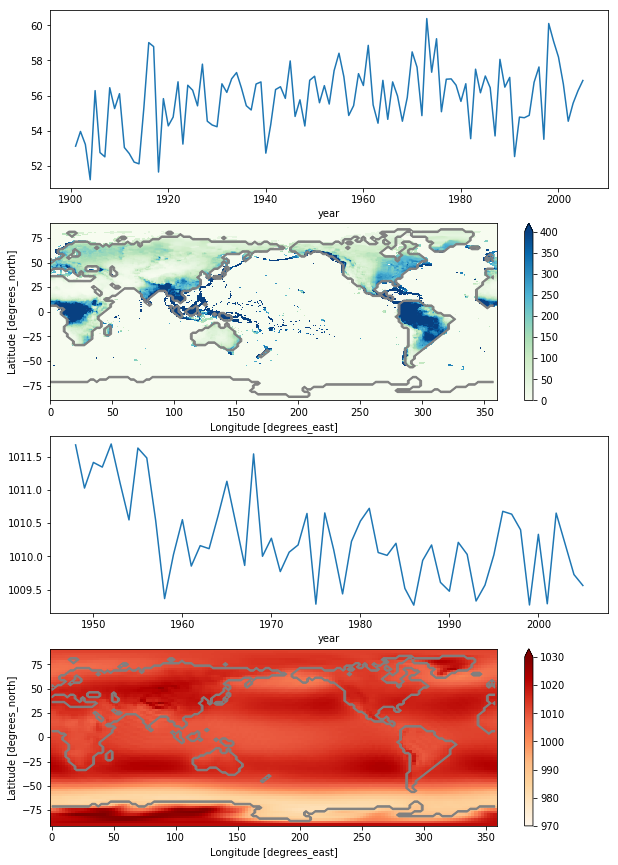

In [45]:
#We keep millibars for SLP, convert to mm/day for precipitation
#prec0 = ds_prec.prate*60*60*24  #1kg of water over 1m^2 is 1mm thick, and 60secs x 60mins x 24hrs in a day
prec0 = ds_prec.precip
slp0 = ds_slp.slp

#Pull out fall season only
precSON = prec0.where(prec0['time.season']=='SON').where(prec0['time.year']<=2005,drop=True).groupby('time.year').sum(dim='time')
slpSON = slp0.where(slp0['time.season']=='SON').where(slp0['time.year']<=2005,drop=True).groupby('time.year').mean(dim='time')

#Fall season plots of precipitation and slp
fig = plt.figure(figsize=(10,15))  #Initialize figure size
#Initialize 3 subplots, assign to variable names ax
axes = fig.subplots(nrows=4)
ax = axes

precSON.mean(dim=['lat','lon']).plot(ax=ax[0]);
precSON.mean(dim='year').plot(ax=ax[1],cmap='GnBu',vmin=0,vmax=400);
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
slpSON.mean(dim=['lat','lon']).plot(ax=ax[2]);
slpSON.mean(dim='year').plot(ax=ax[3],cmap='OrRd',vmin=970,vmax=1030);
lndAv.plot.contour(ax=ax[3],colors='grey',linewidths=1);


In [50]:
#Standardize precipitation and SLP by grid cell
#precAv = precSON.mean(dim='year')
#precSD = precSON.std(dim='year')
#precSON_z = (precSON-precAv)/precSD
precSON_z = precSON


slpAv = slpSON.mean(dim='year')
slpSD = slpSON.std(dim='year')
slpSON_z = (slpSON-slpAv)/slpSD

#Calculate global trends of precipitation
yrs = precSON_z.year.values  #Isolate years (1-70)
precFit = precSON_z.values.reshape(len(yrs),-1)  #Reshape precSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
precTr = np.polyfit(x=yrs,y=precFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coPrec = precTr[0,:].reshape(precSON_z.values.shape[1],precSON_z.values.shape[2])

#Calculate global trends of SLP
yrs = slpSON_z.year.values  #Isolate years (1-70)
slpFit = slpSON_z.values.reshape(len(yrs),-1)  #Reshape slpSON_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
slpTr = np.polyfit(x=yrs,y=slpFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coSLP = slpTr[0,:].reshape(slpSON_z.values.shape[1],slpSON_z.values.shape[2])


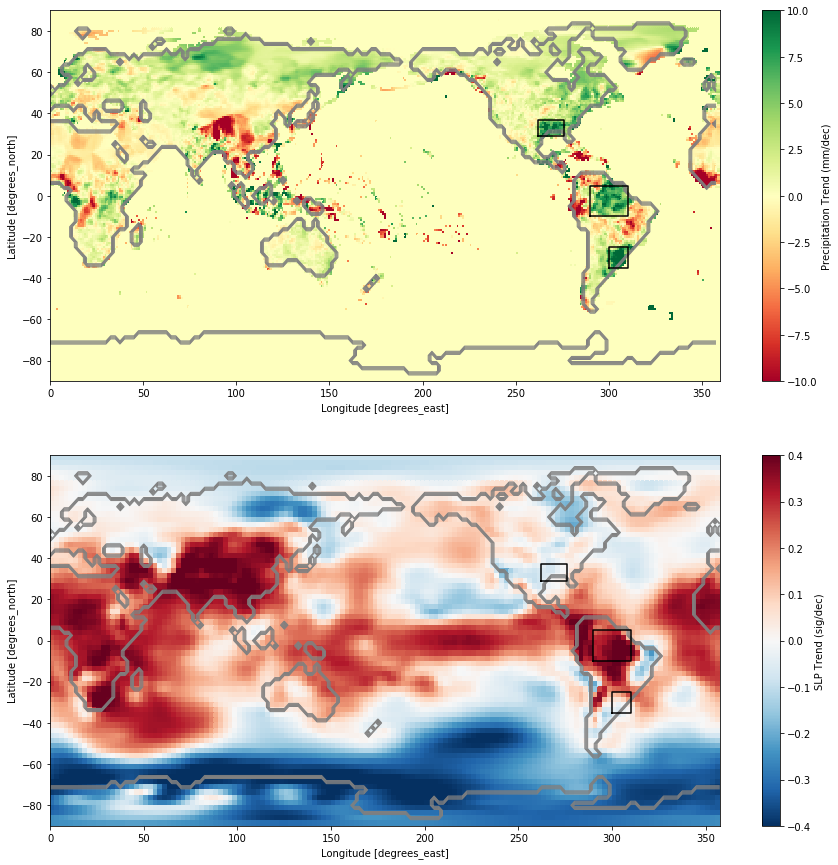

In [51]:
#Fall season trend plots for precipitation and slp
fig = plt.figure(figsize=(15,15))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
axes = fig.subplots(nrows=2)
ax = axes

cbp1 = ax[0].pcolormesh(precSON_z.lon.values,precSON_z.lat.values,10*coPrec,cmap='RdYlGn',vmin=-10,vmax=10);
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-')
ax[0].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-')
ax[0].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-')
lndAv.plot.contour(ax=ax[0],colors='grey',linewidths=1);
cbar1 = fig.colorbar(cbp1,ax=ax[0]);
cbar1.set_label('Precipitation Trend (mm/dec)')
cbp2 = ax[1].pcolormesh(slpSON_z.lon.values,slpSON_z.lat.values,10*coSLP,cmap='RdBu_r',vmin=-.4,vmax=.4);
ax[1].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-')
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-')
ax[1].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-')
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
cbar2 = fig.colorbar(cbp2,ax=ax[1]);
cbar2.set_label('SLP Trend (sig/dec)')


In [63]:
#Calculate correlations between areas of high precipitation trends and SLP

precSON_z = precSON.where(precSON['year']>=1948,drop=True)

precSEUS = precSON_z.sel(lon=slice(262,276),lat=slice(37,29)).mean(dim=['lat','lon'])
precAus = precSON_z.sel(lon=slice(300,310),lat=slice(-25,-35)).mean(dim=['lat','lon'])
precSA = precSON_z.sel(lon=slice(290,310),lat=slice(5,-10)).mean(dim=['lat','lon'])

corrSEUS = xr.DataArray(np.ones((slpSON_z.shape[1],slpSON_z.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': slpSON_z.lat.values,
                         'lon': slpSON_z.lon.values},)

for row in np.arange(0,slpSON_z.shape[1]):
    for col in np.arange(0,slpSON_z.shape[2]):
        corrSEUS.values[row,col] = np.corrcoef(precSEUS.values,slpSON_z.values[:,row,col])[0,1]

corrAus = xr.DataArray(np.ones((slpSON_z.shape[1],slpSON_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpSON_z.lat.values,
                         'lon': slpSON_z.lon.values},)

for row in np.arange(0,slpSON_z.shape[1]):
    for col in np.arange(0,slpSON_z.shape[2]):
        corrAus.values[row,col] = np.corrcoef(precAus.values,slpSON_z.values[:,row,col])[0,1]

corrSA = xr.DataArray(np.ones((slpSON_z.shape[1],slpSON_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpSON_z.lat.values,
                         'lon': slpSON_z.lon.values},)

for row in np.arange(0,slpSON_z.shape[1]):
    for col in np.arange(0,slpSON_z.shape[2]):
        corrSA.values[row,col] = np.corrcoef(precSA.values,slpSON_z.values[:,row,col])[0,1]


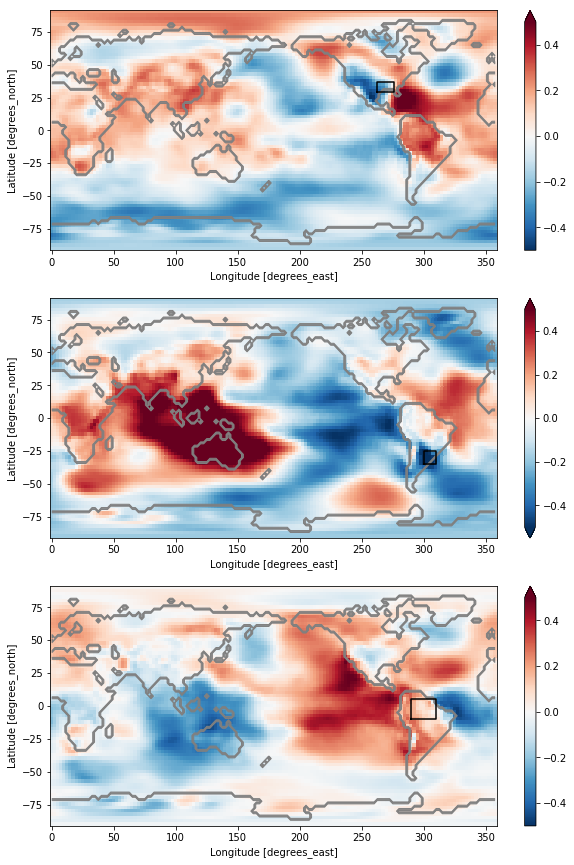

In [53]:
#Fall season correlation plots
fig = plt.figure(figsize=(10,15))  #Initialize figure size
#Initialize 3 subplots, assign to variable names ax
axes = fig.subplots(nrows=3)
ax = axes

corrSEUS.plot.pcolormesh(ax=ax[0],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[0],colors='grey',linewidths=1);
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-');

corrAus.plot.pcolormesh(ax=ax[1],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-');

corrSA.plot.pcolormesh(ax=ax[2],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[2],colors='grey',linewidths=1);
ax[2].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-');


If this is a global phenomenon in fall, southern hemisphere subtropical highs would need to have trends in southern hemisphere fall (northern hemisphere spring).

In [65]:
#Pull out southern hemisphere spring season only
precMAM = prec0.where(prec0['time.season']=='MAM').where(prec0['time.year']<=2005,drop=True).groupby('time.year').sum(dim='time')
slpMAM = slp0.where(slp0['time.season']=='MAM').where(slp0['time.year']<=2005,drop=True).groupby('time.year').mean(dim='time')


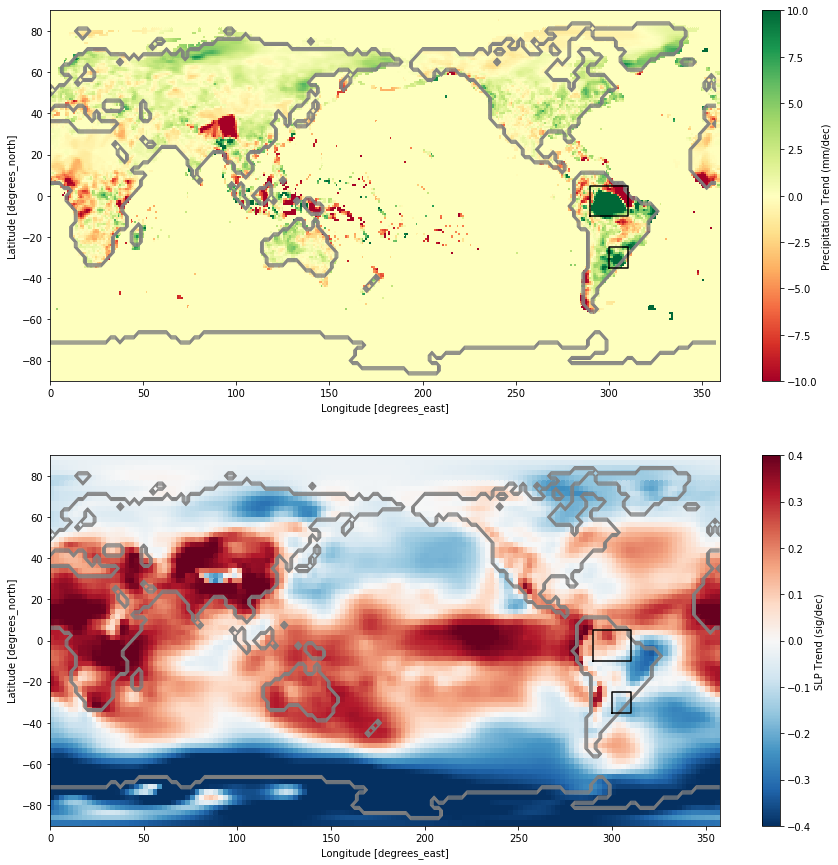

In [67]:
#Standardize precipitation and SLP by grid cell
precMAM_z = precMAM

slpAv = slpMAM.mean(dim='year')
slpSD = slpMAM.std(dim='year')
slpMAM_z = (slpMAM-slpAv)/slpSD

#Calculate global trends of precipitation
yrs = precMAM_z.year.values  #Isolate years (1-70)
precFit = precMAM_z.values.reshape(len(yrs),-1)  #Reshape precMAM_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
precTr = np.polyfit(x=yrs,y=precFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coPrec = precTr[0,:].reshape(precMAM_z.values.shape[1],precMAM_z.values.shape[2])

#Calculate global trends of SLP
yrs = slpMAM_z.year.values  #Isolate years (1-70)
slpFit = slpMAM_z.values.reshape(len(yrs),-1)  #Reshape slpMAM_z to shape of years
#Fit linear regression (1 degree of fitting polynomial = linear regression (y=ax+b))
slpTr = np.polyfit(x=yrs,y=slpFit,deg=1)
#Pull trend coefficients (index=0) and reshape to original shape (lat/lon coordinates)
coSLP = slpTr[0,:].reshape(slpMAM_z.values.shape[1],slpMAM_z.values.shape[2])

#Fall season trend plots for precipitation and slp
fig = plt.figure(figsize=(15,15))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
axes = fig.subplots(nrows=2)
ax = axes

cbp1 = ax[0].pcolormesh(precMAM_z.lon.values,precMAM_z.lat.values,10*coPrec,cmap='RdYlGn',vmin=-10,vmax=10);
ax[0].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-')
ax[0].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-')
lndAv.plot.contour(ax=ax[0],colors='grey',linewidths=1);
cbar1 = fig.colorbar(cbp1,ax=ax[0]);
cbar1.set_label('Precipitation Trend (mm/dec)')
cbp2 = ax[1].pcolormesh(slpMAM_z.lon.values,slpMAM_z.lat.values,10*coSLP,cmap='RdBu_r',vmin=-.4,vmax=.4);
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-')
ax[1].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-')
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
cbar2 = fig.colorbar(cbp2,ax=ax[1]);
cbar2.set_label('SLP Trend (sig/dec)')


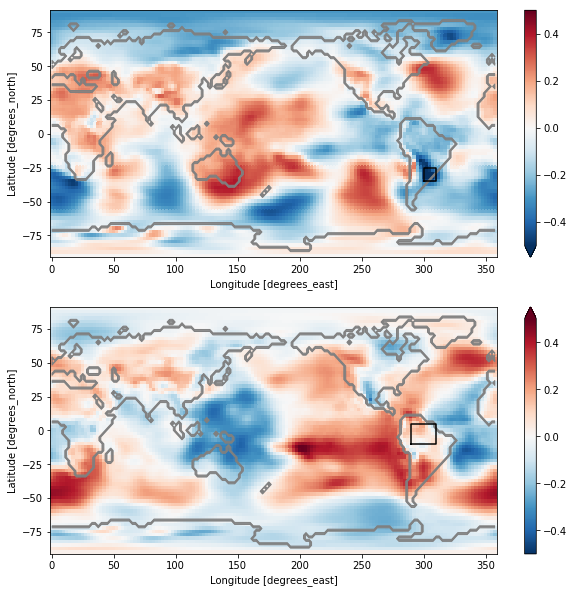

In [69]:
#Calculate correlations between areas of high precipitation trends and SLP

precMAM_z = precMAM.where(precSON['year']>=1948,drop=True)

precAus = precMAM_z.sel(lon=slice(300,310),lat=slice(-25,-35)).mean(dim=['lat','lon'])
precSA = precMAM_z.sel(lon=slice(290,310),lat=slice(5,-10)).mean(dim=['lat','lon'])

corrAus = xr.DataArray(np.ones((slpMAM_z.shape[1],slpMAM_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpMAM_z.lat.values,
                         'lon': slpMAM_z.lon.values},)

for row in np.arange(0,slpMAM_z.shape[1]):
    for col in np.arange(0,slpMAM_z.shape[2]):
        corrAus.values[row,col] = np.corrcoef(precAus.values,slpMAM_z.values[:,row,col])[0,1]

corrSA = xr.DataArray(np.ones((slpMAM_z.shape[1],slpMAM_z.shape[2])),dims=['lat','lon'],
                  coords={'lat': slpMAM_z.lat.values,
                         'lon': slpMAM_z.lon.values},)

for row in np.arange(0,slpMAM_z.shape[1]):
    for col in np.arange(0,slpMAM_z.shape[2]):
        corrSA.values[row,col] = np.corrcoef(precSA.values,slpMAM_z.values[:,row,col])[0,1]

#Fall season correlation plots
fig = plt.figure(figsize=(10,10))  #Initialize figure size
#Initialize 2 subplots, assign to variable names ax
axes = fig.subplots(nrows=2)
ax = axes

corrAus.plot.pcolormesh(ax=ax[0],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[0],colors='grey',linewidths=1);
ax[0].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-');

corrSA.plot.pcolormesh(ax=ax[1],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
ax[1].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-');


## Research Question 2

If a global pattern exists, can we link the subtropical High intensification with global sea-surface temperatures or surface air temperatures?

    Hypothesis: Global increases in subtropical High intensification will be linked to warming
    temperatures globally, although more work will likely be needed to disentangle concurrent
    trends that likely drive the increased correlations.

In [57]:
ds_sst = xr.open_dataset('https://oceanwatch.pfeg.noaa.gov/thredds/dodsC/HadleyCenter/HadISST')
sst0 = ds_sst.sst
sstSON = sst0.where(sst0['time.season']=='SON').where(sst0['time.year']<=2005,drop=True).where(sst0['time.year']>=1948,drop=True).groupby('time.year').mean(dim='time')



In [61]:
#Calculate correlations between areas of high precipitation trends and SST

corrSEUS = xr.DataArray(np.ones((sstSON.shape[1],sstSON.shape[2])),dims=['lat', 'lon'],
                  coords={'lat': sstSON.latitude.values,
                         'lon': sstSON.longitude.values},)

for row in np.arange(0,sstSON.shape[1]):
    for col in np.arange(0,sstSON.shape[2]):
        corrSEUS.values[row,col] = np.corrcoef(precSEUS.values,sstSON.values[:,row,col])[0,1]

corrAus = xr.DataArray(np.ones((sstSON.shape[1],sstSON.shape[2])),dims=['lat','lon'],
                  coords={'lat': sstSON.latitude.values,
                         'lon': sstSON.longitude.values},)

for row in np.arange(0,sstSON.shape[1]):
    for col in np.arange(0,sstSON.shape[2]):
        corrAus.values[row,col] = np.corrcoef(precAus.values,sstSON.values[:,row,col])[0,1]

corrSA = xr.DataArray(np.ones((sstSON.shape[1],sstSON.shape[2])),dims=['lat','lon'],
                  coords={'lat': sstSON.latitude.values,
                         'lon': sstSON.longitude.values},)

for row in np.arange(0,sstSON.shape[1]):
    for col in np.arange(0,sstSON.shape[2]):
        corrSA.values[row,col] = np.corrcoef(precSA.values,sstSON.values[:,row,col])[0,1]



/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


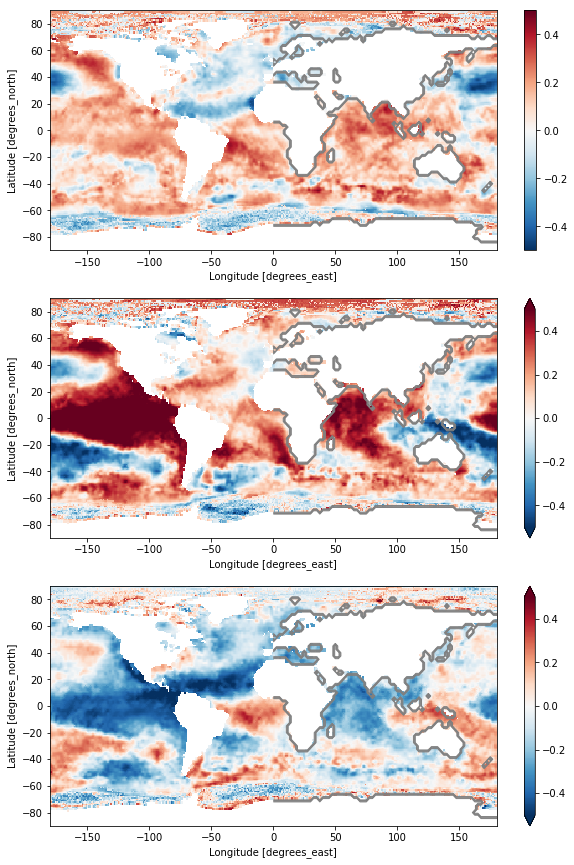

In [62]:
#Fall season correlation plots
fig = plt.figure(figsize=(10,15))  #Initialize figure size
#Initialize 3 subplots, assign to variable names ax
axes = fig.subplots(nrows=3)
ax = axes

corrSEUS.plot.pcolormesh(ax=ax[0],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[0],colors='grey',linewidths=1);
ax[0].plot([360-98,360-84,360-84,360-98,360-98],[29,29,37,37,29],'k-');

corrAus.plot.pcolormesh(ax=ax[1],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[1],colors='grey',linewidths=1);
ax[1].plot([300,310,310,300,300],[-35,-35,-25,-25,-35],'k-');

corrSA.plot.pcolormesh(ax=ax[2],vmin=-.5,vmax=.5,cmap='RdBu_r');
lndAv.plot.contour(ax=ax[2],colors='grey',linewidths=1);
ax[2].plot([290,310,310,290,290],[-10,-10,5,5,-10],'k-');